# COVID-19 in Mexico

## Define the problem
COVID-19 is taking a big toll on the Mexican population. Currently having the 6th place worldwide. I decided to dive in and understand better the current situation in there.

The main question is: 
* Which factor has the biggest impact on deaths once infected with COVID-19?

Other questions to tackle are:
* Is there a correlation between cases and death with days of the week?
* Does the probability of death is increased by the number of days between first symptoms and hospitalization?

In [1]:
__author__ = "Erika Garces"
__email__ = "epgarces3@gmail.com"

In [2]:
# impory libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from os import listdir
import geopandas as gpd
import datetime as dt
from datetime import date

from sklearn import preprocessing

sns.set()
%matplotlib inline

## About datasets

COVID-19 data was taken from Ministry of Health MX:  https://www.gob.mx/salud/documentos/datos-abiertos-152127

Mexico's Shape File was taken from ESRI: https://www.arcgis.com/home/item.html?id=ac9041c51b5c49c683fbfec61dc03ba8

Population data was taken from INEGI and PopulationPyramid.net: 
* https://www.inegi.org.mx/temas/estructura/
* https://www.populationpyramid.net/es/méxico/2020/

## Load the Data 

In [3]:
# Function to print all the files in a folder 
def file_folder (path):
    filepaths = [path + f for f in listdir(path)]
    print (filepaths)

In [4]:
path = "Data/"
covid_general = file_folder(path)

['Data/datos_abiertos_20200810.csv', 'Data/gender.csv', 'Data/.DS_Store', 'Data/Mexico-2020.csv', 'Data/mexstates.dbf', 'Data/Catalogos_0412.xlsx', 'Data/mexstates.shp', 'Data/mexstates.shx', 'Data/mexstates.sbx', 'Data/Poblacion_Edad.xlsx', 'Data/.keep', 'Data/200802COVID19MEXICO.csv', 'Data/clean_data.csv', 'Data/01_poblacion.xls', 'Data/.ipynb_checkpoints', 'Data/mexstates.prj', 'Data/mexstates.sbn', 'Data/mexstates.shp.xml', 'Data/Poblacion_Entidad.xlsx', 'Data/Descriptores_0419.xlsx']


In [5]:
# Loading shape file
geo_states = gpd.read_file(path + "mexstates.shp")

In [6]:
# Loading covid-19 file 
df_genera_mx = pd.read_csv(path +"datos_abiertos_20200810.csv", encoding='latin-1')
df_general = df_genera_mx

In [7]:
#Population data
df_population = pd.read_excel(open(path + 'Poblacion_Entidad.xlsx', 'rb')) 
df_population.head()

,Num,Entidad,Total,Hombres,Mujeres
0,0.0,Estados Unidos Mexicanos,112336538.0,54855231.0,57481307.0
1,1.0,Aguascalientes,1184996.0,576638.0,608358.0
2,2.0,Baja California,3155070.0,1591610.0,1563460.0
3,3.0,Baja California Sur,637026.0,325433.0,311593.0
4,4.0,Campeche,822441.0,407721.0,414720.0


In [8]:
df_gender_pop = pd.read_csv(path + 'Mexico-2020.csv') 
df_gender_pop.head()

,Edad,M,F,Total
0,0-4,5604781,5353961,10958742
1,5-9,5731706,5478805,11210511
2,10-14,5692822,5448048,11140870
3,15-19,5695013,5514580,11209593
4,20-24,5505161,5434658,10939819


In [9]:
#COVID-19 file uses descriptors. The descriptors are analyzed below. 
df_descriptors = pd.read_excel(open(path + 'Descriptores_0419.xlsx', 'rb')) 
df_descriptors.head()

,Nº,NOMBRE DE VARIABLE,DESCRIPCIÓN DE VARIABLE,FORMATO O FUENTE
0,1,FECHA_ACTUALIZACION,"La base de datos se alimenta diariamente, esta...",AAAA-MM-DD
1,2,ID_REGISTRO,Número identificador del caso,TEXTO
2,3,ORIGEN,La vigilancia centinela se realiza a través de...,CATÁLOGO: ORIGEN ...
3,4,SECTOR,Identifica el tipo de institución del Sistema ...,CATÁLOGO: SECTOR ...
4,5,ENTIDAD_UM,Identifica la entidad donde se ubica la unidad...,CATALÓGO: ENTIDADES


In [10]:
df_states = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo de ENTIDADES') 
df_states.head()

,CLAVE_ENTIDAD,ENTIDAD_FEDERATIVA,ABREVIATURA
0,1,AGUASCALIENTES,AS
1,2,BAJA CALIFORNIA,BC
2,3,BAJA CALIFORNIA SUR,BS
3,4,CAMPECHE,CC
4,5,COAHUILA DE ZARAGOZA,CL


In [11]:
df_sector = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo SECTOR') 
df_sector.head()

,CLAVE,DESCRIPCIÓN
0,1,CRUZ ROJA
1,2,DIF
2,3,ESTATAL
3,4,IMSS
4,5,IMSS-BIENESTAR


In [12]:
df_paciente = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo TIPO_PACIENTE') 
df_paciente

,CLAVE,DESCRIPCIÓN
0,1,AMBULATORIO
1,2,HOSPITALIZADO
2,99,NO ESPECIFICADO


In [13]:
df_gender = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo SEXO') 
df_gender

,CLAVE,DESCRIPCIÓN
0,1,MUJER
1,2,HOMBRE
2,99,NO ESPECIFICADO


## Examine data

In [14]:
# checking the size of the file 
df_general.shape 

(1097077, 35)

In [15]:
# checking the data type of the columns
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097077 entries, 0 to 1097076
Data columns (total 35 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   FECHA_ACTUALIZACION  1097077 non-null  object
 1   ID_REGISTRO          1097077 non-null  object
 2   ORIGEN               1097077 non-null  int64 
 3   SECTOR               1097077 non-null  int64 
 4   ENTIDAD_UM           1097077 non-null  int64 
 5   SEXO                 1097077 non-null  int64 
 6   ENTIDAD_NAC          1097077 non-null  int64 
 7   ENTIDAD_RES          1097077 non-null  int64 
 8   MUNICIPIO_RES        1097077 non-null  int64 
 9   TIPO_PACIENTE        1097077 non-null  int64 
 10  FECHA_INGRESO        1097077 non-null  object
 11  FECHA_SINTOMAS       1097077 non-null  object
 12  FECHA_DEF            1097077 non-null  object
 13  INTUBADO             1097077 non-null  int64 
 14  NEUMONIA             1097077 non-null  int64 
 15  EDAD           

In [16]:
#checking the first 5 rows.
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-08-10,1db186,2,3,15,1,15,15,76,1,...,2,1,2,2,1,1,99,MÃ©xico,99,97
1,2020-08-10,19b7a9,2,3,27,2,27,27,13,1,...,2,2,2,2,1,1,99,MÃ©xico,99,97
2,2020-08-10,1ae47a,2,4,9,1,14,9,5,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
3,2020-08-10,0e345e,2,4,30,1,30,30,193,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
4,2020-08-10,170aea,2,4,9,2,15,15,104,1,...,2,2,2,1,99,1,99,MÃ©xico,99,97


In [17]:
df_general.describe()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,UCI
count,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,...,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06,1.097077e+06
mean,1.660297e+00,9.256658e+00,1.574382e+01,1.497618e+00,1.654355e+01,1.597487e+01,3.817259e+01,1.189506e+00,7.899428e+01,1.865096e+00,...,2.097876e+00,2.373475e+00,2.234929e+00,2.089718e+00,2.232300e+00,2.187798e+00,2.993797e+01,1.629358e+00,9.862667e+01,7.899555e+01
std,4.736085e-01,3.650954e+00,8.169230e+00,4.999946e-01,9.918174e+00,8.084673e+00,4.890814e+01,3.919104e-01,3.725510e+01,5.138165e-01,...,5.017803e+00,6.183433e+00,4.946658e+00,4.905011e+00,4.901369e+00,5.086167e+00,4.436928e+01,6.145521e-01,6.015040e+00,3.725258e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,4.000000e+00,9.000000e+00,1.000000e+00,9.000000e+00,9.000000e+00,8.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,9.900000e+01,9.700000e+01
50%,2.000000e+00,1.200000e+01,1.500000e+01,1.000000e+00,1.500000e+01,1.500000e+01,2.100000e+01,1.000000e+00,9.700000e+01,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,9.900000e+01,9.700000e+01
75%,2.000000e+00,1.200000e+01,2.300000e+01,2.000000e+00,2.400000e+01,2.300000e+01,4.800000e+01,1.000000e+00,9.700000e+01,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,9.900000e+01,2.000000e+00,9.900000e+01,9.700000e+01
max,2.000000e+00,9.900000e+01,3.200000e+01,2.000000e+00,9.900000e+01,3.200000e+01,9.990000e+02,2.000000e+00,9.900000e+01,9.900000e+01,...,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.900000e+01,3.000000e+00,9.900000e+01,9.900000e+01


In [18]:
columns_ = df_general.columns
print(columns_)

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES',
       'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'RESULTADO', 'MIGRANTE', 'PAIS_NACIONALIDAD',
       'PAIS_ORIGEN', 'UCI'],
      dtype='object')


In [19]:
def value_counter(df, columns):
    for col in columns:
        result = df[col].value_counts()
        print (result) 

In [20]:

columns_remove = ('SECTOR','ORIGEN','FECHA_ACTUALIZACION', 'ID_REGISTRO','ENTIDAD_UM', 'EDAD',
                  'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES','FECHA_INGRESO', 
                  'FECHA_SINTOMAS', 'FECHA_DEF','PAIS_NACIONALIDAD', 'MIGRANTE', 'PAIS_ORIGEN')
columns_review = [col for col in columns_ if col not in columns_remove]

In [21]:
value_counter(df_general, columns_review)

1    551152
2    545925
Name: SEXO, dtype: int64
1    889174
2    207903
Name: TIPO_PACIENTE, dtype: int64
97    889174
2     189734
1      18013
99       156
Name: INTUBADO, dtype: int64
2     947411
1     149649
99        17
Name: NEUMONIA, dtype: int64
1    1091772
2       5305
Name: NACIONALIDAD, dtype: int64
97    545925
2     539213
1       8314
98      3625
Name: EMBARAZO, dtype: int64
2     1049999
99      37338
1        9740
Name: HABLA_LENGUA_INDIG, dtype: int64
2     957257
1     136589
98      3231
Name: DIABETES, dtype: int64
2     1078792
1       15459
98       2826
Name: EPOC, dtype: int64
2     1062007
1       32249
98       2821
Name: ASMA, dtype: int64
2     1079278
1       14690
98       3109
Name: INMUSUPR, dtype: int64
2     915491
1     178607
98      2979
Name: HIPERTENSION, dtype: int64
2     1064003
1       28509
98       4565
Name: OTRA_COM, dtype: int64
2     1071863
1       22297
98       2917
Name: CARDIOVASCULAR, dtype: int64
2     919443
1     174788
98  

## Pre-processing data

In [22]:
df_population = df_population.dropna(how='all')
df_population['Num'] = df_population['Num'].astype(int)

In [23]:
df_general['ENTIDAD'] = df_general['ENTIDAD_UM'].map(df_states.set_index('CLAVE_ENTIDAD')['ABREVIATURA'])
df_general['ENTIDAD_NAME'] = df_general['ENTIDAD_UM'].map(df_states.set_index('CLAVE_ENTIDAD')['ENTIDAD_FEDERATIVA'])
df_general['SECTOR'] = df_general['SECTOR'].map(df_sector.set_index('CLAVE')['DESCRIPCIÓN'])

In [24]:
df_general['TIPO_PACIENTE'] = df_general['TIPO_PACIENTE'].map(df_paciente.set_index('CLAVE')['DESCRIPCIÓN'])
df_general['SEXO']= df_general['SEXO'].replace([1, 2], ['Women', 'Men'])


In [25]:
# It replace values for several columns in a dataframe.
def replace_values(df, columns, 
                   old_values, new_values):
    for col in columns:
        try:
            df[col]= df[col].replace(to_replace=old_values, value=new_values)
        except:
            print(col)
    return df 

In [26]:
# It cast values for several columns in a dataframe.
def cast_values(df, columns, cast_value):
    for col in columns:
        try:
            df[col]= df[col].astype(cast_value)
        except:
            print(col)
    return df 

The columns below are dropped. 

In [27]:
df_general = df_general.drop(['ENTIDAD_NAC', 'ENTIDAD_RES', 'NACIONALIDAD', 
                              'PAIS_NACIONALIDAD', 'HABLA_LENGUA_INDIG', 'MIGRANTE'], axis=1)

The column ['FECHA_DEF'] uses '9999-99-99', so I imputed this value to zero. This helps further calculations. 

In [28]:
df_general['FECHA_DEF'] = df_general['FECHA_DEF'].replace('9999-99-99', 0)

In [29]:
df_general['DEF'] = df_general.FECHA_DEF.apply(lambda x: 1 if x!=0 else 0)

In [30]:
#the columns were formatted to datetime.
df_general['FECHA_INGRESO'] = pd.to_datetime(df_general['FECHA_INGRESO'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_SINTOMAS'] = pd.to_datetime(df_general['FECHA_SINTOMAS'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_DEF'] = pd.to_datetime(df_general['FECHA_DEF'].str.strip(), format='%Y/%m/%d', errors='ignore')

In [31]:
def cal_time_days(df, column_a, column_b, new_name):
    df[new_name] = df[column_a] -  df[column_b]
    df[new_name] = df[new_name].dt.days.astype("Int32")
    df[new_name] = df[new_name].fillna(0)
    return df

In [32]:
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,PAIS_ORIGEN,UCI,ENTIDAD,ENTIDAD_NAME,DEF
0,2020-08-10,1db186,2,ESTATAL,15,Women,76,AMBULATORIO,2020-05-14,2020-05-11,...,1,2,2,1,1,99,97,MC,MÉXICO,0
1,2020-08-10,19b7a9,2,ESTATAL,27,Men,13,AMBULATORIO,2020-06-19,2020-06-11,...,2,2,2,1,1,99,97,TC,TABASCO,1
2,2020-08-10,1ae47a,2,IMSS,9,Women,5,AMBULATORIO,2020-04-01,2020-03-28,...,2,2,2,99,1,99,97,DF,CIUDAD DE MÉXICO,0
3,2020-08-10,0e345e,2,IMSS,30,Women,193,AMBULATORIO,2020-04-15,2020-04-12,...,2,2,2,99,1,99,97,VZ,VERACRUZ DE IGNACIO DE LA LLAVE,0
4,2020-08-10,170aea,2,IMSS,9,Men,104,AMBULATORIO,2020-04-16,2020-04-08,...,2,2,1,99,1,99,97,DF,CIUDAD DE MÉXICO,1


Added columns to know number of days between:
* a patient had symptoms to his/her death.
* a patient has symptoms to be hospitalized.
* a patient was hospitalized symptoms to his/her death.
    


In [33]:
cal_time_days(df_general,'FECHA_DEF', 'FECHA_SINTOMAS', 'DIAS_SINT_DEF')
cal_time_days(df_general,'FECHA_DEF', 'FECHA_INGRESO', 'DIAS_ING_DEF')
cal_time_days(df_general,'FECHA_INGRESO', 'FECHA_SINTOMAS', 'DIAS_SINT_ING')

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,OTRO_CASO,RESULTADO,PAIS_ORIGEN,UCI,ENTIDAD,ENTIDAD_NAME,DEF,DIAS_SINT_DEF,DIAS_ING_DEF,DIAS_SINT_ING
0,2020-08-10,1db186,2,ESTATAL,15,Women,76,AMBULATORIO,2020-05-14,2020-05-11,...,1,1,99,97,MC,MÉXICO,0,0,0,3
1,2020-08-10,19b7a9,2,ESTATAL,27,Men,13,AMBULATORIO,2020-06-19,2020-06-11,...,1,1,99,97,TC,TABASCO,1,15,7,8
2,2020-08-10,1ae47a,2,IMSS,9,Women,5,AMBULATORIO,2020-04-01,2020-03-28,...,99,1,99,97,DF,CIUDAD DE MÉXICO,0,0,0,4
3,2020-08-10,0e345e,2,IMSS,30,Women,193,AMBULATORIO,2020-04-15,2020-04-12,...,99,1,99,97,VZ,VERACRUZ DE IGNACIO DE LA LLAVE,0,0,0,3
4,2020-08-10,170aea,2,IMSS,9,Men,104,AMBULATORIO,2020-04-16,2020-04-08,...,99,1,99,97,DF,CIUDAD DE MÉXICO,1,21,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097072,2020-08-10,19a698,2,PEMEX,4,Men,53,AMBULATORIO,2020-08-08,2020-08-08,...,1,3,99,97,CC,CAMPECHE,0,0,0,0
1097073,2020-08-10,0944a4,1,SSA,16,Women,53,HOSPITALIZADO,2020-08-08,2020-08-01,...,1,3,99,2,MN,MICHOACÁN DE OCAMPO,0,0,0,7
1097074,2020-08-10,07dcc2,1,SSA,19,Women,18,AMBULATORIO,2020-08-09,2020-07-27,...,2,3,99,97,NL,NUEVO LEÓN,0,0,0,13
1097075,2020-08-10,1843c5,1,ISSSTE,9,Women,5,HOSPITALIZADO,2020-08-08,2020-07-30,...,99,3,99,2,DF,CIUDAD DE MÉXICO,0,0,0,9


The column specifies whether the patient is alive or dead.

In [34]:
df_general['FECHA_INGRESO_SEMANAL'] = df_general['FECHA_INGRESO'].dt.dayofweek
df_general['WEEKEND'] = df_general['FECHA_INGRESO_SEMANAL'].apply(lambda x: 1 if (x>4) else 0)

In [35]:
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,PAIS_ORIGEN,UCI,ENTIDAD,ENTIDAD_NAME,DEF,DIAS_SINT_DEF,DIAS_ING_DEF,DIAS_SINT_ING,FECHA_INGRESO_SEMANAL,WEEKEND
0,2020-08-10,1db186,2,ESTATAL,15,Women,76,AMBULATORIO,2020-05-14,2020-05-11,...,99,97,MC,MÉXICO,0,0,0,3,3,0
1,2020-08-10,19b7a9,2,ESTATAL,27,Men,13,AMBULATORIO,2020-06-19,2020-06-11,...,99,97,TC,TABASCO,1,15,7,8,4,0
2,2020-08-10,1ae47a,2,IMSS,9,Women,5,AMBULATORIO,2020-04-01,2020-03-28,...,99,97,DF,CIUDAD DE MÉXICO,0,0,0,4,2,0
3,2020-08-10,0e345e,2,IMSS,30,Women,193,AMBULATORIO,2020-04-15,2020-04-12,...,99,97,VZ,VERACRUZ DE IGNACIO DE LA LLAVE,0,0,0,3,2,0
4,2020-08-10,170aea,2,IMSS,9,Men,104,AMBULATORIO,2020-04-16,2020-04-08,...,99,97,DF,CIUDAD DE MÉXICO,1,21,13,8,3,0


I decided to impute the data from values [97,98 and 99] to be 'no'. The values are used in the columns of preconditions of patients. Many times care providers mark as not applicable when a patient doesn't present the condition. 

In [36]:
#Selecting the columns that have a format of SI and NO.
df_descriptors['FORMATO O FUENTE'] = df_descriptors['FORMATO O FUENTE'].str.strip()
df_si_no_answer = df_descriptors[df_descriptors['FORMATO O FUENTE']== 'CATÁLOGO: SI_ NO']
column_list_binary = list(df_si_no_answer['NOMBRE DE VARIABLE'].values)
column_list_binary.append('RESULTADO')
column_list_binary.append('OTRO_CASO')
column_list_binary.append('OTRA_COM')
column_list_binary

['INTUBADO',
 'NEUMONIA',
 'EMBARAZO',
 'HABLA_LENGUA_INDIG',
 'DIABETES',
 'EPOC',
 'ASMA',
 'INMUSUPR',
 'HIPERTENSION',
 'OTRAS_COM',
 'CARDIOVASCULAR',
 'OBESIDAD',
 'RENAL_CRONICA',
 'TABAQUISMO',
 'OTRO_CASO',
 'MIGRANTE',
 'UCI',
 'RESULTADO',
 'OTRO_CASO',
 'OTRA_COM']

In [37]:
#The values for the columns with SI NO format are replace with 1 and 0.
df_general =replace_values(df_general, column_list_binary, [97, 98, 99], [2,2,2])
df_general =replace_values(df_general, column_list_binary, [1,2], [1,0])


HABLA_LENGUA_INDIG
OTRAS_COM
MIGRANTE
HABLA_LENGUA_INDIG
OTRAS_COM
MIGRANTE


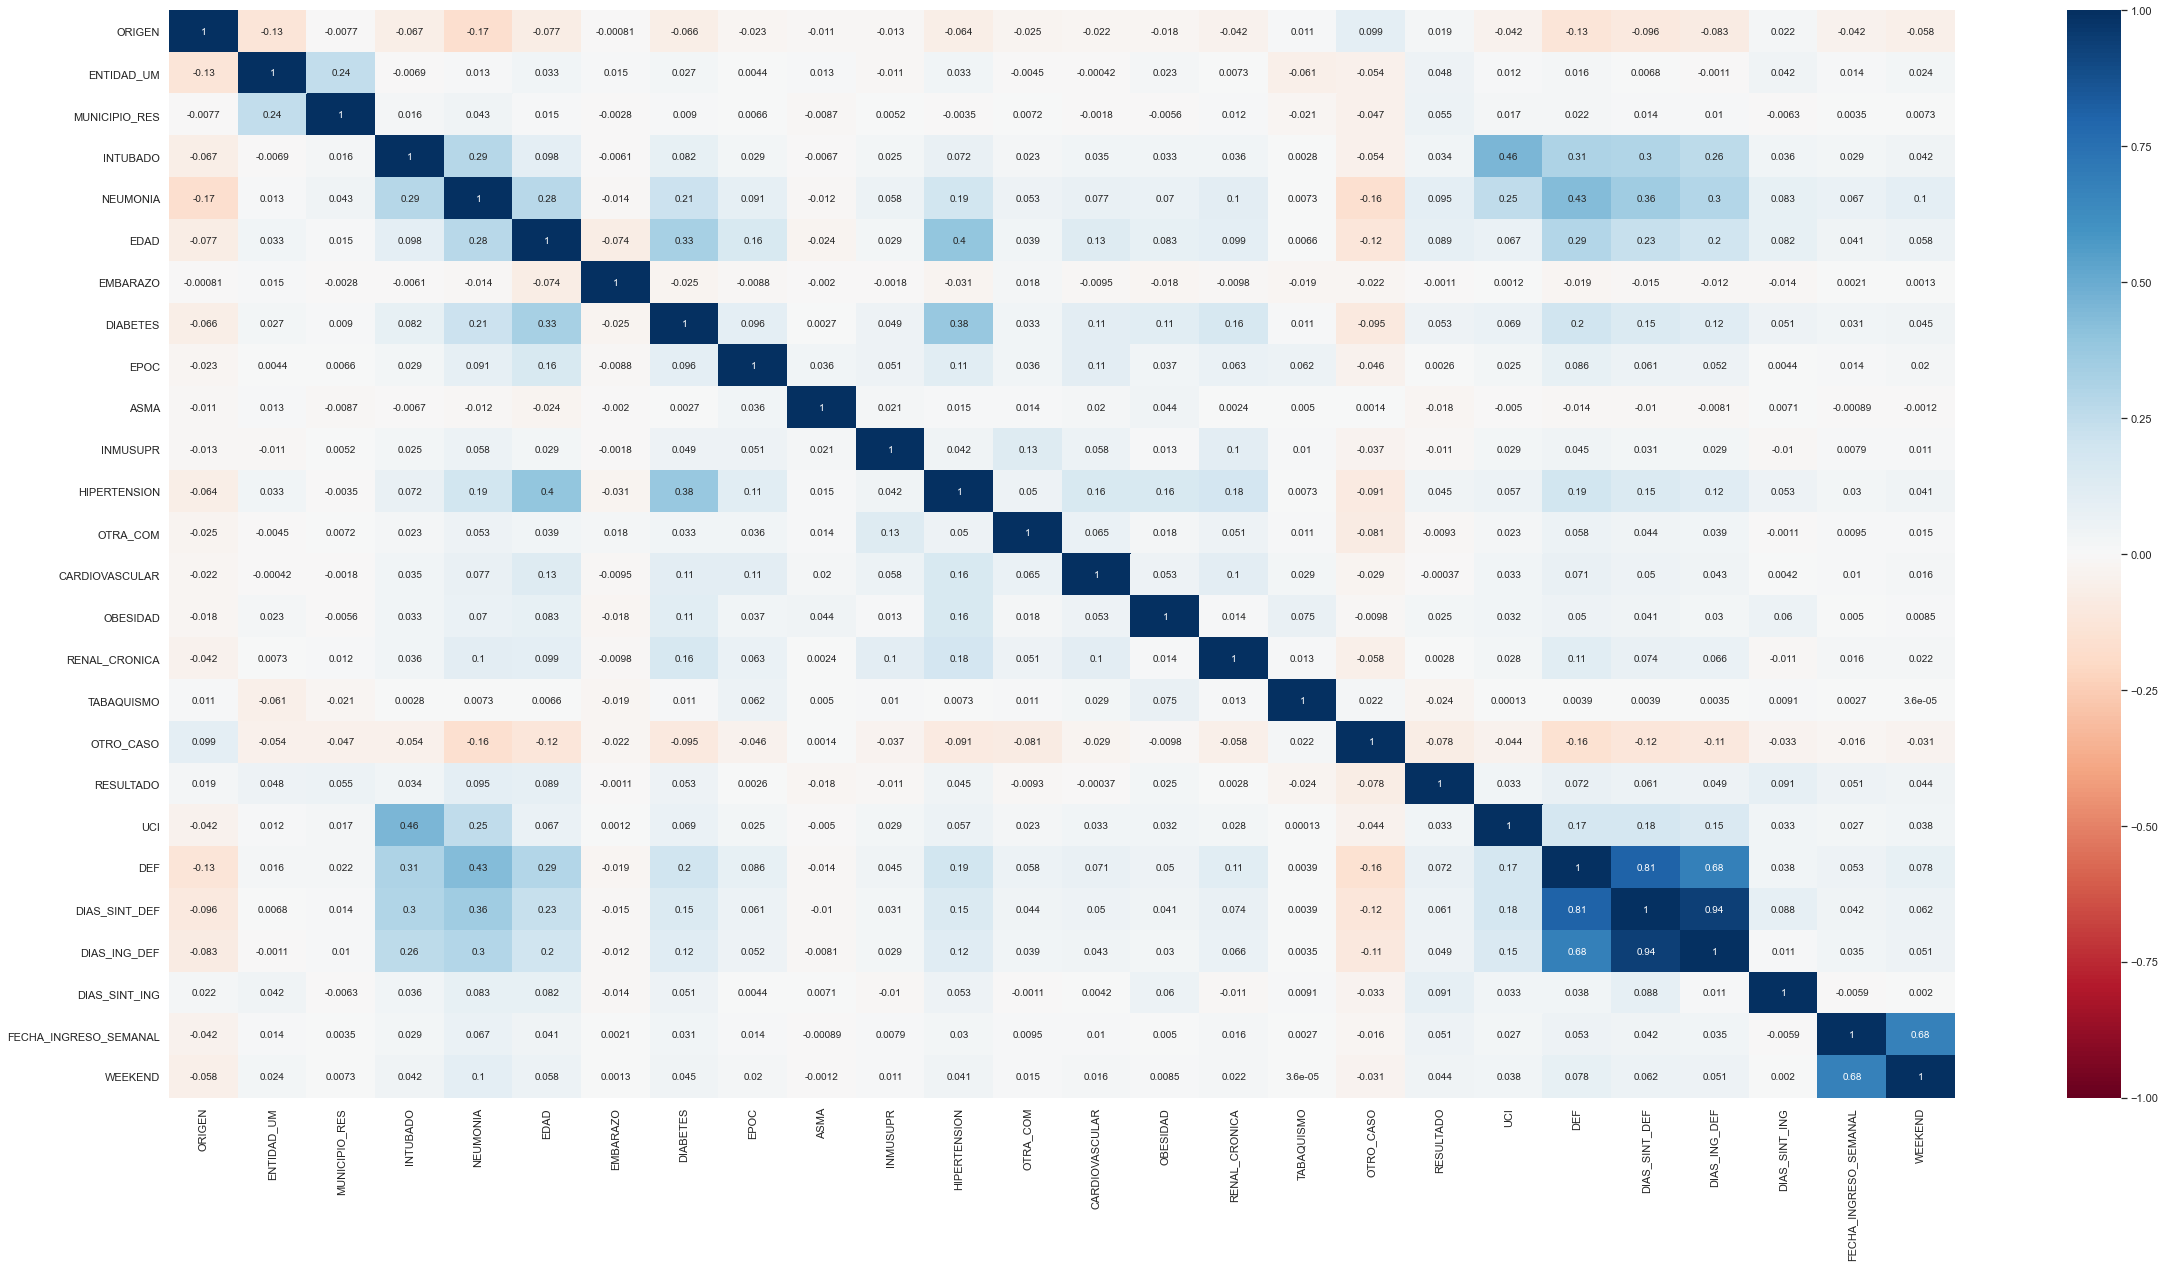

In [38]:
correlation = df_general.corr()
plt.figure(figsize=(40, 20))
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu")

In [39]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097077 entries, 0 to 1097076
Data columns (total 37 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   FECHA_ACTUALIZACION    1097077 non-null  object        
 1   ID_REGISTRO            1097077 non-null  object        
 2   ORIGEN                 1097077 non-null  int64         
 3   SECTOR                 1097077 non-null  object        
 4   ENTIDAD_UM             1097077 non-null  int64         
 5   SEXO                   1097077 non-null  object        
 6   MUNICIPIO_RES          1097077 non-null  int64         
 7   TIPO_PACIENTE          1097077 non-null  object        
 8   FECHA_INGRESO          1097077 non-null  datetime64[ns]
 9   FECHA_SINTOMAS         1097077 non-null  datetime64[ns]
 10  FECHA_DEF              68049 non-null    datetime64[ns]
 11  INTUBADO               1097077 non-null  int64         
 12  NEUMONIA               10970

In [40]:
#df_clea_data = df_general.to_csv(path + 'clean_data.csv',index=False)

## Exploratory Data Analysis 

### States with more COVID-19 tests



The figure below shows percentage of COVID-19 tests done in Mexico broken by state. Mexico city is the federal entity with the most number of tests. In second place is Mexico (the state). 

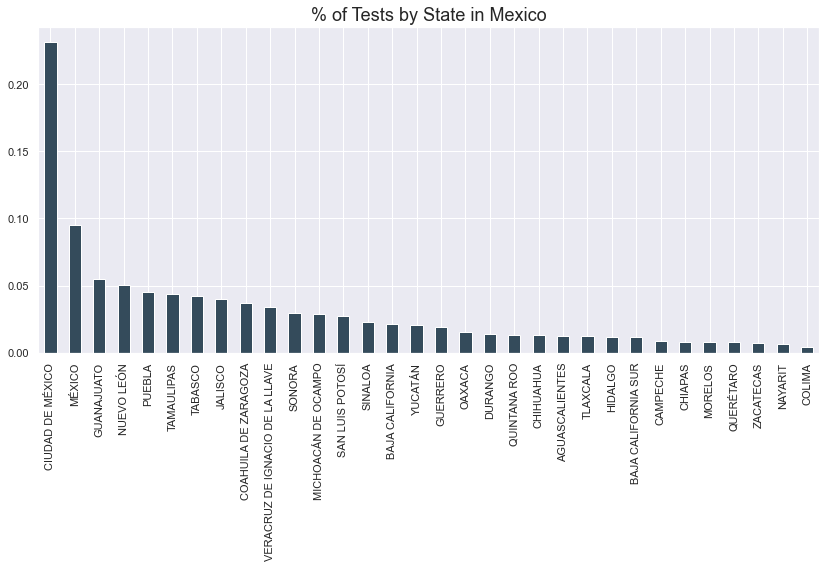

In [41]:
states_vals = df_general.ENTIDAD_NAME.value_counts()
sns.set(palette="Blues_d")
fig = plt.figure(figsize=(14,6))
(states_vals/df_general.shape[0]).plot(kind="bar");
plt.title("% of Tests by State in Mexico", fontsize = 18);
plt.show()

In [42]:
states_vals.sum()/ df_gender_pop.Total.sum() * 100

0.8508908516054101

The data frame is filtered, to focus on only on patient with COVID-19.

In [43]:
df_states_by_result = df_general.copy()
indexPendintResult = df_states_by_result[ df_states_by_result['RESULTADO'] == 3 ].index
df_states_by_result.drop(indexPendintResult , inplace=True)
df_states_by_result['RESULTADO'].replace(to_replace=[1,0], value=['POSITIVO','NO POSITIVO'],inplace=True)

In [44]:
pd.crosstab(df_states_by_result.FECHA_ACTUALIZACION, df_states_by_result.RESULTADO)

RESULTADO,NO POSITIVO,POSITIVO
FECHA_ACTUALIZACION,,
2020-08-10,532028,485836


In [45]:
df_state_results = pd.crosstab(df_states_by_result.ENTIDAD, df_states_by_result.RESULTADO, normalize=True)

In [46]:
df_state_results = df_state_results.reset_index()

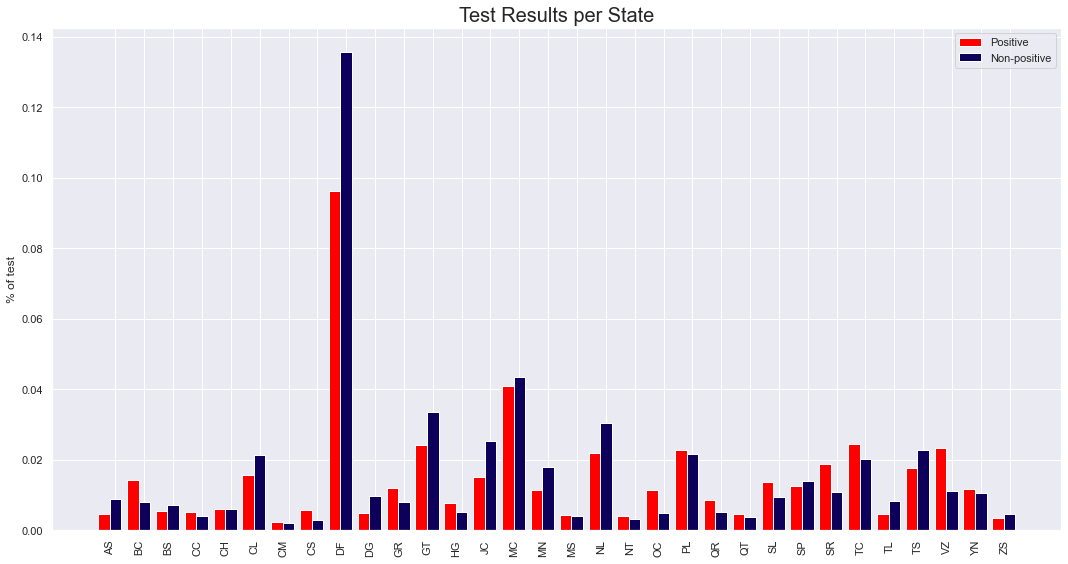

In [47]:
width = 0.40
x = np.arange(len(df_state_results.ENTIDAD))
fig, ax = plt.subplots(figsize=(15, 8))

rects1 = ax.bar(x - width/2, df_state_results.POSITIVO, width, label='Positive', color = '#ff0000')
rects2 = ax.bar(x + width/2, df_state_results['NO POSITIVO'], width, label='Non-positive', color = '#0c005a')

ax.set_ylabel('% of test')
ax.set_title('Test Results per State', fontsize = 20)
ax.set_xticks(x + width/2 )
ax.set_xticklabels(df_state_results.ENTIDAD, rotation=90, ha='right')
ax.legend()
fig.tight_layout()

plt.show()

The graph shows the results of the tests done by federal entity. The results in the graphs have been normalized.

## Values  per Capita

In [48]:
df_states_key_vals = df_general.ENTIDAD_UM.value_counts().to_frame()
df_states_key_vals = df_states_key_vals.reset_index()
df_states_key_vals.rename(columns={df_states_key_vals.columns[0]: 'abbr' ,
                                   'ENTIDAD_UM':  'VALUES'}, inplace = True)

In [49]:
df_population = pd.merge(df_population, df_states_key_vals, left_on='Num', right_on='abbr')

In [50]:
df_population['PER_CAPITA'] = df_population['VALUES'] / df_population['Total'] * 100000

In [51]:
df_population['VALUES'].sum() / df_population['Total'].sum() * 100000

976.598548906679

In [52]:
df_population['abbr'] = df_population['abbr'].map(df_states.set_index('CLAVE_ENTIDAD')['ABREVIATURA'])

In [53]:
df_population.sort_values('Total', ascending=False)

,Num,Entidad,Total,Hombres,Mujeres,abbr,VALUES,PER_CAPITA
14,15,México,15175862.0,7396986.0,7778876.0,MC,104618,689.371055
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,253520,2864.283229
29,30,Veracruz de Ignacio de la Llave,7643194.0,3695679.0,3947515.0,VZ,37353,488.709301
13,14,Jalisco,7350682.0,3600641.0,3750041.0,JC,43953,597.944517
20,21,Puebla,5779829.0,2769855.0,3009974.0,PL,49422,855.077200
10,11,Guanajuato,5486372.0,2639425.0,2846947.0,GT,59937,1092.470580
6,7,Chiapas,4796580.0,2352807.0,2443773.0,CS,8904,185.632263
18,19,Nuevo León,4653458.0,2320185.0,2333273.0,NL,55513,1192.940819
15,16,Michoacán de Ocampo,4351037.0,2102109.0,2248928.0,MN,31363,720.816670
19,20,Oaxaca,3801962.0,1819008.0,1982954.0,OC,17181,451.898257


In [54]:
df_population.sort_values('PER_CAPITA', ascending=False)

,Num,Entidad,Total,Hombres,Mujeres,abbr,VALUES,PER_CAPITA
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,253520,2864.283229
2,3,Baja California Sur,637026.0,325433.0,311593.0,BS,13089,2054.704204
26,27,Tabasco,2238603.0,1100758.0,1137845.0,TC,45986,2054.227570
4,5,Coahuila de Zaragoza,2748391.0,1364197.0,1384194.0,CL,40792,1484.213855
27,28,Tamaulipas,3268554.0,1616201.0,1652353.0,TS,48158,1473.373241
25,26,Sonora,2662480.0,1339612.0,1322868.0,SR,32459,1219.126529
18,19,Nuevo León,4653458.0,2320185.0,2333273.0,NL,55513,1192.940819
23,24,San Luis Potosí,2585518.0,1260366.0,1325152.0,SP,30355,1174.039399
30,31,Yucatán,1955577.0,963333.0,992244.0,YN,22954,1173.771219
0,1,Aguascalientes,1184996.0,576638.0,608358.0,AS,13880,1171.311971


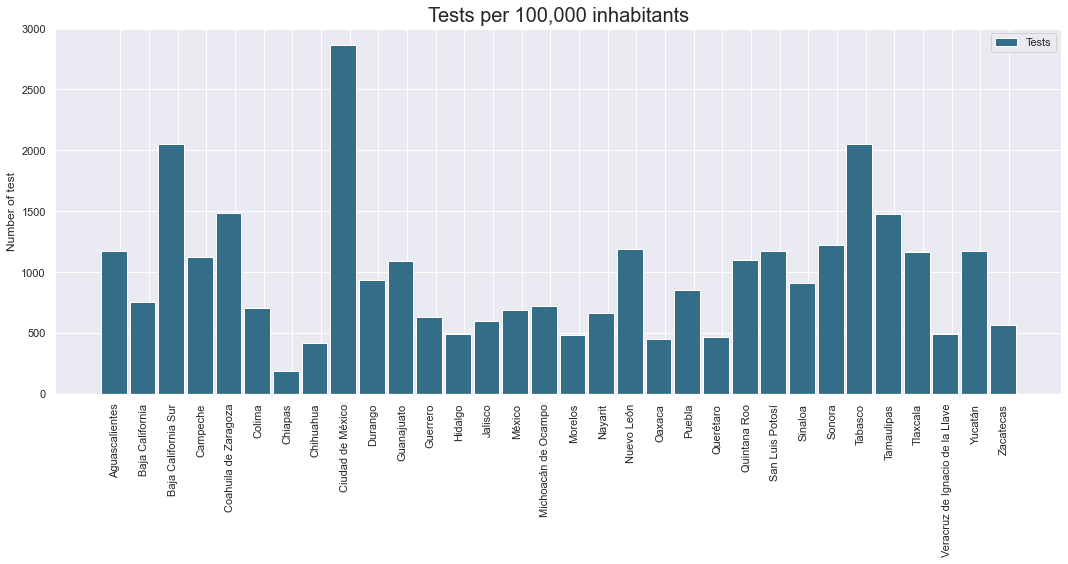

In [55]:
width = 0.9 
x = np.arange(len(df_population.Entidad))
fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(x, df_population['PER_CAPITA'], width, label='Tests', color = '#336d88')
ax.set_ylabel('Number of test')
ax.set_title('Tests per 100,000 inhabitants', fontsize = 20)
ax.set_xticks(x + width/4 )
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right')
ax.legend()

fig.tight_layout()

plt.show()

### Positive cases per 100,000 inhabitants

In [56]:
df_result_tests = df_states_by_result.groupby(['ENTIDAD_UM', 'RESULTADO']).size().unstack()

In [57]:
df_result_tests = df_result_tests.reset_index()

In [58]:
df_population = pd.merge(df_population, df_result_tests, left_on='Num', right_on='ENTIDAD_UM')

In [59]:
# positive cases per capita
df_population['POS_PER_CAPITA'] = df_population['POSITIVO'] / df_population['Total'] * 100000

In [60]:
df_population.sort_values('POS_PER_CAPITA', ascending=False)

,Num,Entidad,Total,Hombres,Mujeres,abbr,VALUES,PER_CAPITA,ENTIDAD_UM,NO POSITIVO,POSITIVO,POS_PER_CAPITA
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,253520,2864.283229,9,138161,97916,1106.260479
26,27,Tabasco,2238603.0,1100758.0,1137845.0,TC,45986,2054.227570,27,20541,24736,1104.974844
2,3,Baja California Sur,637026.0,325433.0,311593.0,BS,13089,2054.704204,3,7207,5624,882.852505
25,26,Sonora,2662480.0,1339612.0,1322868.0,SR,32459,1219.126529,26,10855,19204,721.282413
22,23,Quintana Roo,1325578.0,673220.0,652358.0,QR,14536,1096.578247,23,5267,8693,655.789399
3,4,Campeche,822441.0,407721.0,414720.0,CC,9265,1126.524577,4,3970,5126,623.266593
30,31,Yucatán,1955577.0,963333.0,992244.0,YN,22954,1173.771219,31,10789,11757,601.203635
4,5,Coahuila de Zaragoza,2748391.0,1364197.0,1384194.0,CL,40792,1484.213855,5,21638,15851,576.737444
27,28,Tamaulipas,3268554.0,1616201.0,1652353.0,TS,48158,1473.373241,28,23201,18040,551.926020
24,25,Sinaloa,2767761.0,1376201.0,1391560.0,SL,25134,908.098640,25,9673,13825,499.501221


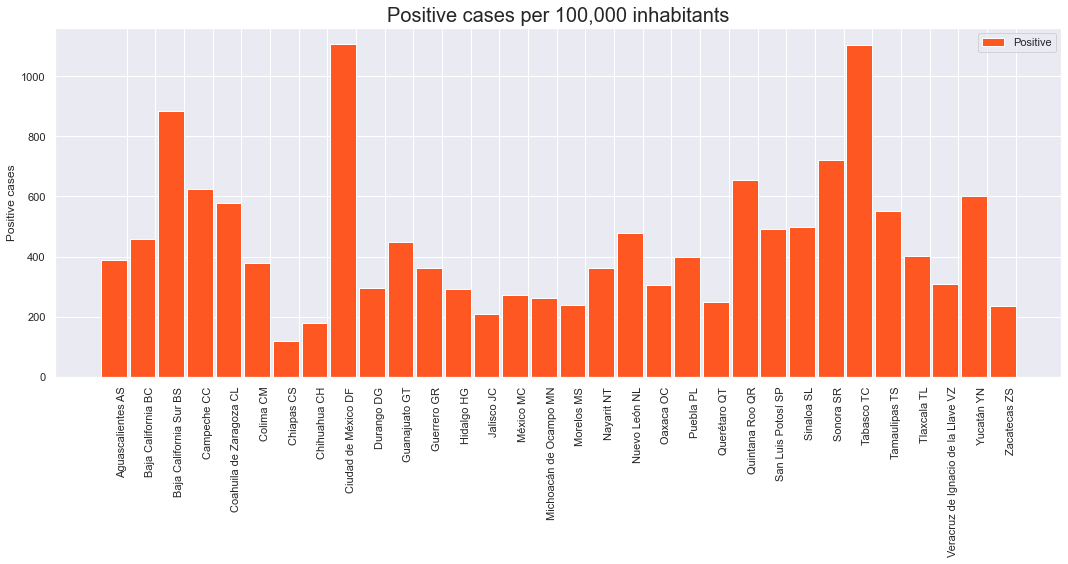

In [112]:
width = 0.9 
x = np.arange(len(df_population.Entidad))
fig, ax = plt.subplots(figsize=(15, 8))

ax.bar(x, df_population['POS_PER_CAPITA'], width, label='Positive', color = '#ff5722')
ax.set_ylabel('Positive cases')
ax.set_title('Positive cases per 100,000 inhabitants', fontsize = 20)
ax.set_xticks(x + width/2 )
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right')
ax.legend()
fig.tight_layout()

plt.show()

In [78]:
df_population.sort_values('Total', ascending=False)

,Num,Entidad,Total,Hombres,Mujeres,abbr,VALUES,PER_CAPITA,ENTIDAD_UM,NO POSITIVO,POSITIVO,POS_PER_CAPITA,POS_NOR
14,15,México,15175862.0,7396986.0,7778876.0,MC,104618,689.371055,15,44120,41474,273.289254,0.085366
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,253520,2864.283229,9,138161,97916,1106.260479,0.201541
29,30,Veracruz de Ignacio de la Llave,7643194.0,3695679.0,3947515.0,VZ,37353,488.709301,30,11274,23655,309.491032,0.048689
13,14,Jalisco,7350682.0,3600641.0,3750041.0,JC,43953,597.944517,14,25715,15421,209.790058,0.031741
20,21,Puebla,5779829.0,2769855.0,3009974.0,PL,49422,855.077200,21,22069,23037,398.575806,0.047417
10,11,Guanajuato,5486372.0,2639425.0,2846947.0,GT,59937,1092.470580,11,33985,24548,447.435938,0.050527
6,7,Chiapas,4796580.0,2352807.0,2443773.0,CS,8904,185.632263,7,3014,5722,119.293330,0.011778
18,19,Nuevo León,4653458.0,2320185.0,2333273.0,NL,55513,1192.940819,19,30988,22186,476.763731,0.045666
15,16,Michoacán de Ocampo,4351037.0,2102109.0,2248928.0,MN,31363,720.816670,16,18305,11451,263.178640,0.023570
19,20,Oaxaca,3801962.0,1819008.0,1982954.0,OC,17181,451.898257,20,4784,11577,304.500676,0.023829


In [63]:
# positve cases normalized
['POS_NOR'] = df_population.POSITIVO/ df_population.POSITIVO.sum()

In [64]:
df_population.sort_values('POS_NOR', ascending=False)

,Num,Entidad,Total,Hombres,Mujeres,abbr,VALUES,PER_CAPITA,ENTIDAD_UM,NO POSITIVO,POSITIVO,POS_PER_CAPITA,POS_NOR
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,253520,2864.283229,9,138161,97916,1106.260479,0.201541
14,15,México,15175862.0,7396986.0,7778876.0,MC,104618,689.371055,15,44120,41474,273.289254,0.085366
26,27,Tabasco,2238603.0,1100758.0,1137845.0,TC,45986,2054.227570,27,20541,24736,1104.974844,0.050914
10,11,Guanajuato,5486372.0,2639425.0,2846947.0,GT,59937,1092.470580,11,33985,24548,447.435938,0.050527
29,30,Veracruz de Ignacio de la Llave,7643194.0,3695679.0,3947515.0,VZ,37353,488.709301,30,11274,23655,309.491032,0.048689
20,21,Puebla,5779829.0,2769855.0,3009974.0,PL,49422,855.077200,21,22069,23037,398.575806,0.047417
18,19,Nuevo León,4653458.0,2320185.0,2333273.0,NL,55513,1192.940819,19,30988,22186,476.763731,0.045666
25,26,Sonora,2662480.0,1339612.0,1322868.0,SR,32459,1219.126529,26,10855,19204,721.282413,0.039528
27,28,Tamaulipas,3268554.0,1616201.0,1652353.0,TS,48158,1473.373241,28,23201,18040,551.926020,0.037132
4,5,Coahuila de Zaragoza,2748391.0,1364197.0,1384194.0,CL,40792,1484.213855,5,21638,15851,576.737444,0.032626


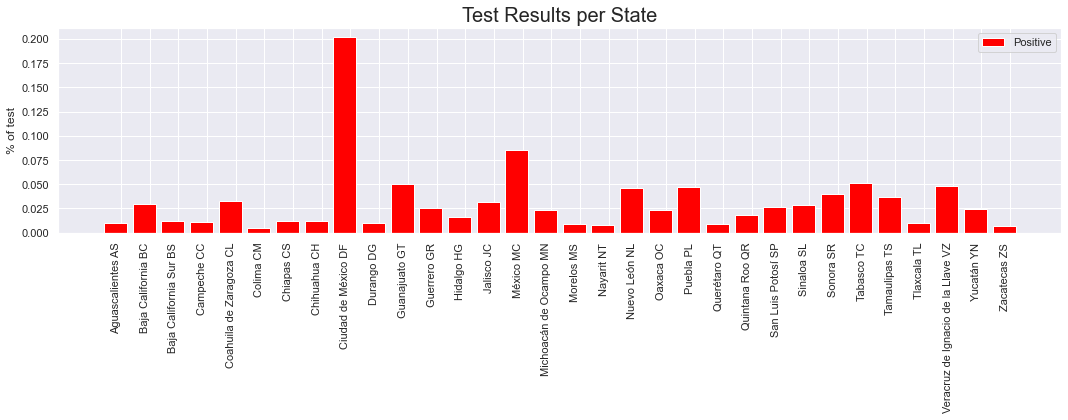

In [111]:
width = 0.8
x = np.arange(len(df_state_results.ENTIDAD))
fig, ax = plt.subplots(figsize=(15, 6))

rects1 = ax.bar(x, df_population.POS_NOR, width, label='Positive', color = '#ff0000')

ax.set_ylabel('% of test')
ax.set_title('Test Results per State', fontsize = 20)
ax.set_xticks(x + width/4)
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right')
ax.legend()
fig.tight_layout()

plt.show()

In [108]:
df_population['Entidad'] = df_population[['Entidad', 'abbr']].agg(' '.join, axis=1)

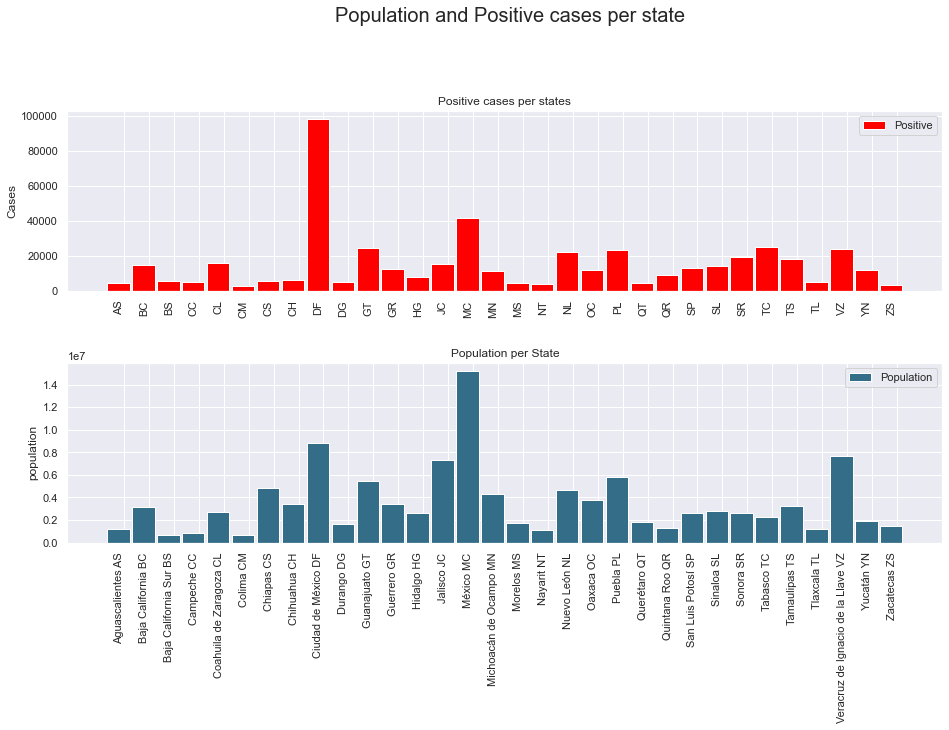

In [110]:
width = 0.9 
fig, axs =plt.subplots(2,1, figsize=(15, 8))

axs[0].bar(x, df_population.POSITIVO, width, label='Positive', color = '#ff0000')

axs[0].set_title('Positive cases per states')
axs[0].set_ylabel('Cases')
axs[0].set_xticks(x + width/4)
axs[0].set_xticklabels(df_population.abbr, rotation=90, ha='right')
axs[0].legend()

axs[1].bar(x, df_population.Total, width, label='Population', color = '#336d88')
axs[1].set_title('Population per State')
axs[1].set_ylabel('population')
axs[1].set_xticks(x + width/4)
axs[1].set_xticklabels(df_population.Entidad, rotation=90, ha='right')
axs[1].legend()

fig.suptitle('Population and Positive cases per state', fontsize=20)
fig.subplots_adjust(left=0.09, right=0.9, bottom=0.05, top=0.8,
                    hspace=0.4, wspace=0.3)

###  Summary of Confimed/Deaths

In [67]:
df_positive = df_general[ df_general['RESULTADO'] == 1]
df_positive = df_positive[['FECHA_ACTUALIZACION','FECHA_INGRESO', 'FECHA_DEF',
                           'RESULTADO', 'DEF', 'DIAS_SINT_ING', 'SEXO', 'EDAD']]

In [68]:
df_positive.rename({'EDAD': "Age"}, axis=1, inplace=True)

In [69]:
df_positive.DEF.sum()

53003

In [70]:
def bar_char (x_val, y_val, color_num, title_chart, y_axis_name, x_axis_name, i = False, figsize=(15,6) ):
    fig, ax = plt.subplots(figsize= figsize)
    x_pos = np.arange(len(x_val))

    ax.bar(x_pos, y_val, color=color_num)
    ax.set_ylabel(y_axis_name)
    ax.set_xlabel(x_axis_name)
    ax.set_title(title_chart, fontsize = 20)
    
    if i:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_val, rotation=90, ha='right')
        ax.legend()
        fig.tight_layout()

    plt.show()
    
    
    

In [71]:
df_death = pd.crosstab(df_positive['FECHA_DEF'], df_positive.DEF)
df_death = df_death.reset_index()
df_death.rename({1: 'DEF'}, axis=1, inplace=True)

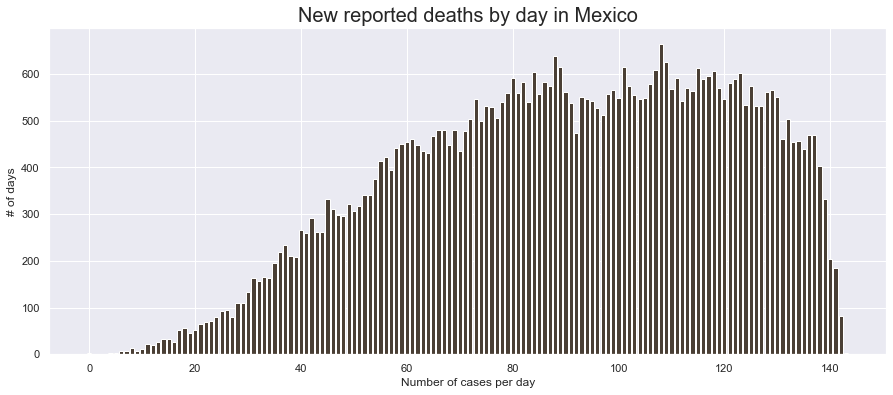

In [72]:
bar_char(df_death.FECHA_DEF, 
         df_death.DEF, 
         '#4a3f35', 
         'New reported deaths by day in Mexico', 
         '# of days',
         'Number of cases per day')

In [73]:
df_dying  = df_general[(df_general['RESULTADO'] == 1 ) & (df_general['DEF'] == 1 )]
df_dying = df_dying[['FECHA_DEF','DIAS_SINT_DEF', 'FECHA_INGRESO_SEMANAL', 'SEXO']]
df_dying.set_index('FECHA_DEF', inplace=True)
df_dying.index = pd.to_datetime(df_dying.index)

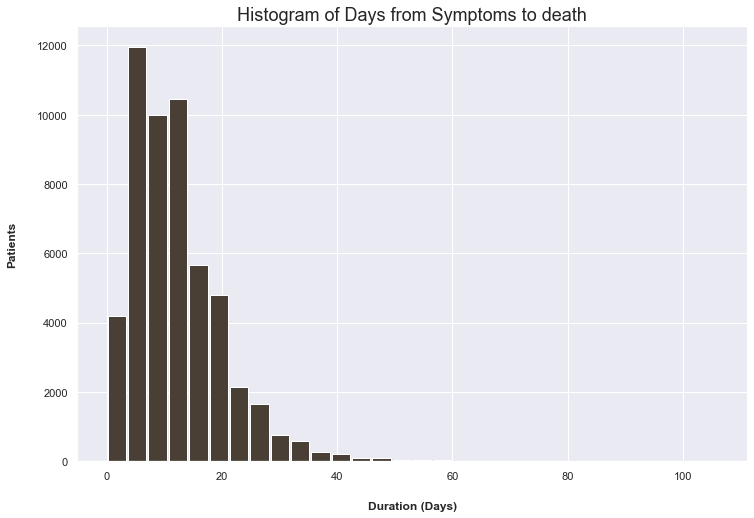

In [74]:
ax = df_dying.hist(column='DIAS_SINT_DEF', bins=30, grid=True, figsize=(12,8), color='#4a3f35',  rwidth=0.9)

for x in ax[0]:
    x.set_title("Histogram of Days from Symptoms to death", fontsize = 18)
    x.set_xlabel("Duration (Days)", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Patients", labelpad=20, weight='bold', size=12)



In [75]:
outlier = df_dying[df_dying['DIAS_SINT_DEF']>30].count()
outlier

DIAS_SINT_DEF            1652
FECHA_INGRESO_SEMANAL    1652
SEXO                     1652
dtype: int64

The avergare number of days for a patient with COVID19 to dies is almost 12. There are cases that takes up to more than 3 months.


In [76]:
df_dying.describe()

,DIAS_SINT_DEF,FECHA_INGRESO_SEMANAL
count,53003.000000,53003.000000
mean,12.258721,2.861197
std,8.109882,1.990591
min,0.000000,0.000000
25%,7.000000,1.000000
50%,11.000000,3.000000
75%,16.000000,5.000000
max,106.000000,6.000000


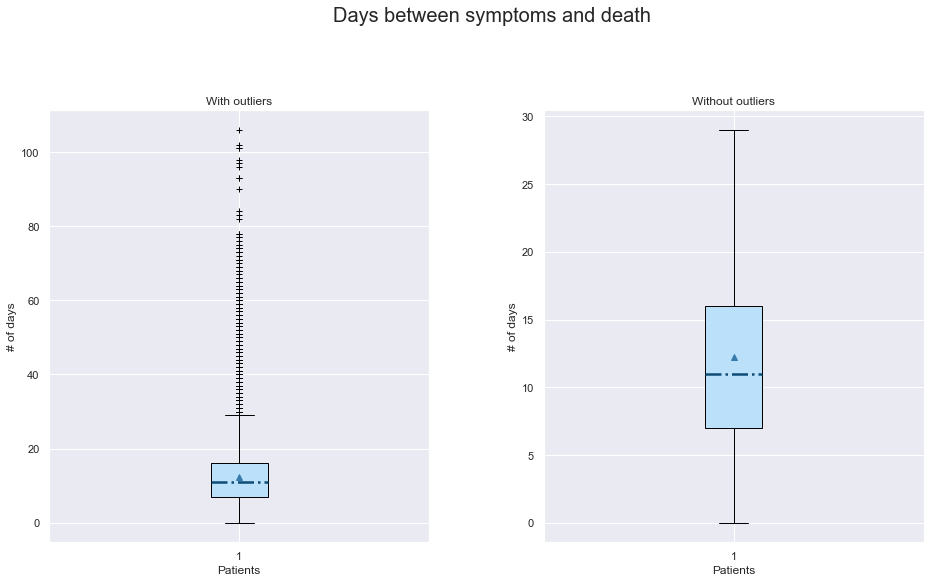

In [79]:
fig, axs =plt.subplots(1,2, figsize=(15, 8))
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
medianprops = dict(linestyle='-.', linewidth=2.5, color='#0f4c75')

axs[0].boxplot(df_dying['DIAS_SINT_DEF'],notch=0, sym='+', vert=1, whis=1.5,  patch_artist=True, 
               medianprops=medianprops, boxprops=dict(facecolor='#bbe1fa'),showmeans=True )
axs[0].set_title('With outliers')
axs[0].set_ylabel('# of days')
axs[0].set_xlabel('Patients')

axs[1].boxplot(df_dying['DIAS_SINT_DEF'], 0, '', patch_artist=True, 
               boxprops=dict(facecolor='#bbe1fa'), showmeans=True, medianprops=medianprops)
axs[1].set_title("Without outliers")
axs[1].set_ylabel('# of days')
axs[1].set_xlabel('Patients')

fig.suptitle('Days between symptoms and death', fontsize=20)
fig.subplots_adjust(left=0.09, right=0.9, bottom=0.05, top=0.8,
                    hspace=0.4, wspace=0.3)

The boxplots show the distribution between number of days from first symptoms to death. The first boxplot includes outlier. In the second boxplot the outliers are removed.

### Confirmed Positive COVID-19 cases

In [80]:
df_gender_pop = df_gender_pop.dropna()


In [81]:
df_gender_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Edad    21 non-null     object
 1   M       21 non-null     int64 
 2   F       21 non-null     int64 
 3   Total   21 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 840.0+ bytes


In [82]:
gender_vals = list(df_positive.SEXO.value_counts(normalize=True))

In [83]:
gender_vals

[0.5293308853193258, 0.4706691146806741]

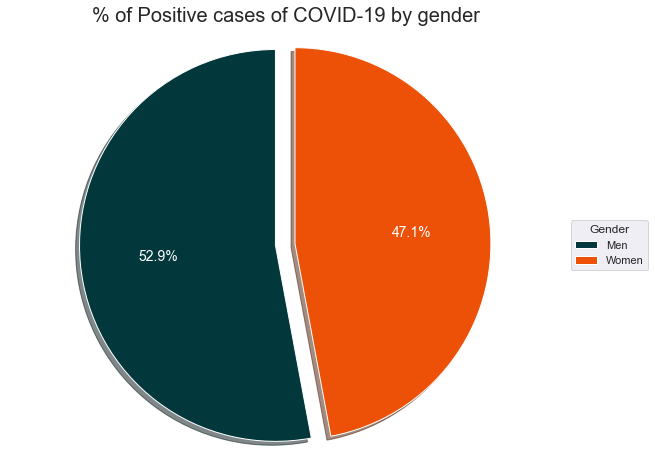

In [84]:
labels ='Men', 'Women',
sizes = gender_vals
cs = ['#02383c', '#ed5107']
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots(figsize=(10, 8))

wedges, texts, autotexts =  ax.pie(sizes, colors= cs, explode=explode, labels=labels, autopct='%1.1f%%',
                                   shadow=True, startangle=90, textprops={'fontsize': 14, 'color':"w"})

ax.set_title('% of Positive cases of COVID-19 by gender', fontsize = 20)
ax.legend(wedges, labels,
          title="Gender",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [85]:
# Percentage population by gender
pop_gender_nor_list = list()
pop_gender_nor_list.append(df_gender_pop.M.sum()/df_gender_pop.Total.sum())
pop_gender_nor_list.append(df_gender_pop.F.sum()/df_gender_pop.Total.sum())
pop_gender_nor_list

[0.48918125559608583, 0.5108187444039142]

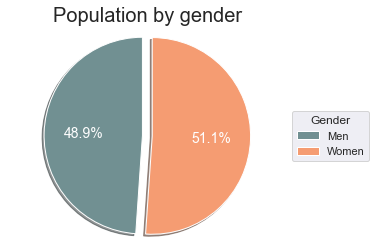

In [86]:
labels ='Men', 'Women',
sizes = pop_gender_nor_list
cs = ['#719092', '#F59C72']
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots(figsize=(5, 4))

wedges, texts, autotexts =  ax.pie(sizes, colors= cs, explode=explode, labels=labels, autopct='%1.1f%%',
                                   shadow=True, startangle=90, textprops={'fontsize': 14, 'color':"w"})

ax.set_title('Population by gender', fontsize = 20)
ax.legend(wedges, labels,
          title="Gender",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [87]:
pop_gender_list = list()
pop_gender_list.append(df_gender_pop.M.sum())
pop_gender_list.append(df_gender_pop.F.sum())

In [88]:
gender_values = list(df_positive.SEXO.value_counts())
gender = ['men','women']

In [89]:
dict = {'gender': gender, 'Covid': gender_values, 'Population': pop_gender_list}  
    
df_total_gender = pd.DataFrame(dict) 

In [90]:
df_total_gender['Ratio_Covid_Total'] = df_total_gender.Covid/df_total_gender.Population
df_total_gender

,gender,Covid,Population,Ratio_Covid_Total
0,men,257168,63071486,0.004077
1,women,228668,65861267,0.003472


No handles with labels found to put in legend.


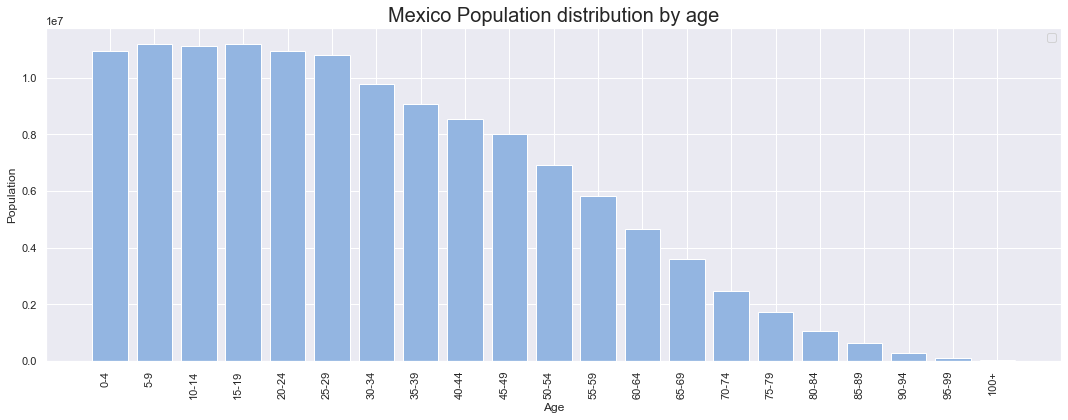

In [91]:
bar_char(df_gender_pop.Edad, 
         df_gender_pop.Total,
         '#93b5e1', 
         'Mexico Population distribution by age', 
         'Population',
         'Age',
          True)

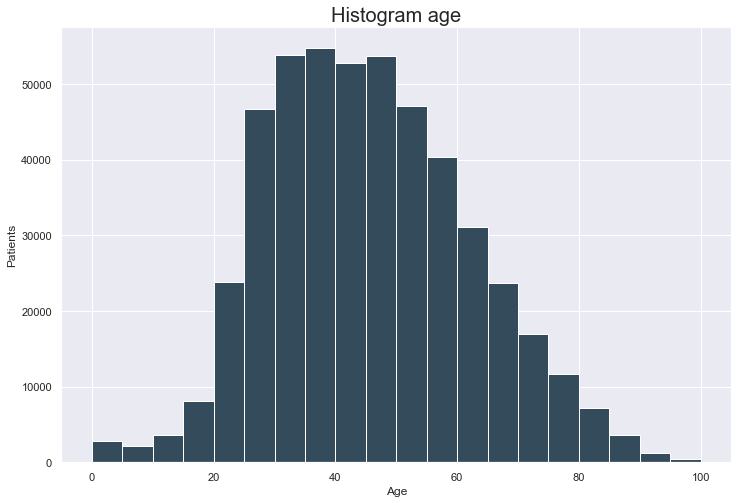

In [92]:
import numpy as np
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(12,8))

bins_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# create the histogram
(n, bins, patches) = plt.hist(df_positive.Age, bins=bins_list,   label='hst')


plt.xlabel('Age', fontsize = 12)
plt.ylabel('Patients',  size=12)
plt.title('Histogram age',  size=20)

plt.grid(True)
plt.show()

In [93]:
covid_age_list = n

In [94]:
# Add the last element to match the size of dataframe gender population
covid_age_list= np.insert(covid_age_list, 20,0)

In [95]:
len(covid_age_list) 

21

In [96]:
df_gender_pop['Cases_Covid'] = covid_age_list

In [97]:
df_gender_pop['Ratio_Covid_Total'] = df_gender_pop.Cases_Covid/df_gender_pop.Total

In [98]:
df_gender_pop

,Edad,M,F,Total,Cases_Covid,Ratio_Covid_Total
0,0-4,5604781,5353961,10958742,2861.0,0.000261
1,5-9,5731706,5478805,11210511,2200.0,0.000196
2,10-14,5692822,5448048,11140870,3615.0,0.000324
3,15-19,5695013,5514580,11209593,8054.0,0.000718
4,20-24,5505161,5434658,10939819,23770.0,0.002173
5,25-29,5384130,5411644,10795774,46689.0,0.004325
6,30-34,4748412,5041468,9789880,53884.0,0.005504
7,35-39,4343789,4746361,9090150,54743.0,0.006022
8,40-44,4029738,4502226,8531964,52763.0,0.006184
9,45-49,3782769,4233025,8015794,53680.0,0.006697


No handles with labels found to put in legend.


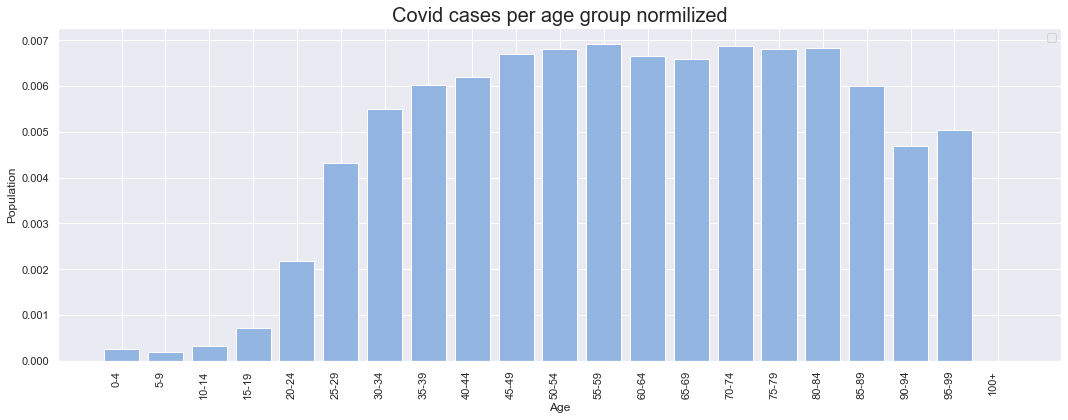

In [99]:
bar_char(df_gender_pop.Edad, 
         df_gender_pop.Ratio_Covid_Total,
         '#93b5e1', 
         'Covid cases per age group normilized', 
         'Population',
         'Age',
          True)

In [100]:
df_age_women = df_positive[df_positive.SEXO == 'Women']
df_age_men = df_positive[df_positive.SEXO == 'Men']
age_women = list(df_age_women['Age'])
age_men = list(df_age_men['Age'])

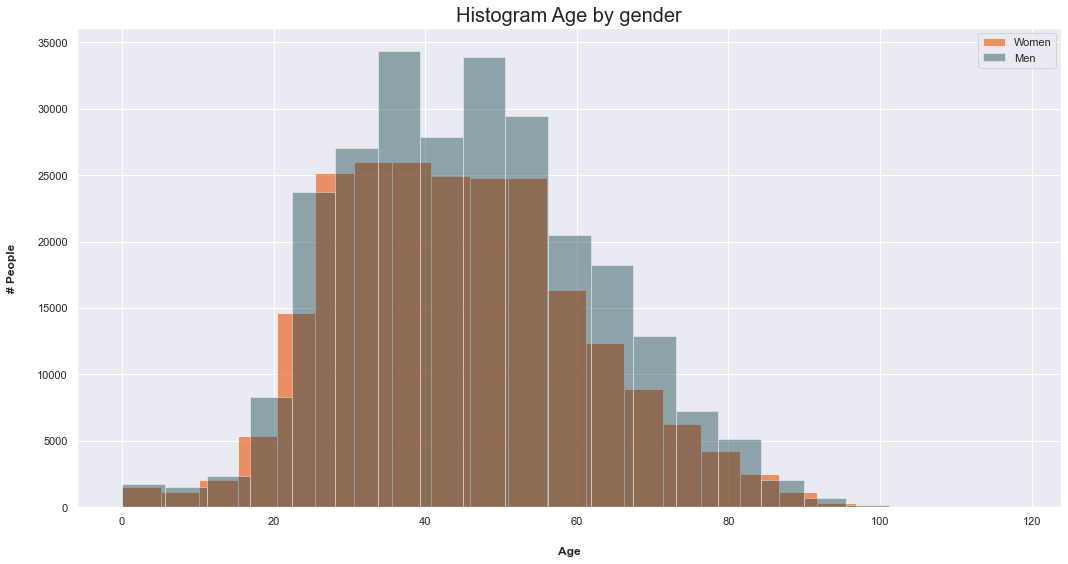

In [101]:
fig, ax =plt.subplots(figsize=(15, 8))

bins = 21 
ax.hist(age_women, bins, alpha=0.6, label='Women', color='#ed5107' )
ax.hist(age_men, bins, alpha=0.4, label='Men', color='#02383c')
ax.legend()
ax.set_title('Histogram Age by gender', fontsize = 20)
ax.set_xlabel("Age", labelpad=20, weight='bold', size=12)
ax.set_ylabel("# People", labelpad=20, weight='bold', size=12)
fig.tight_layout()

plt.show()

Histogram of age broken by gender. 

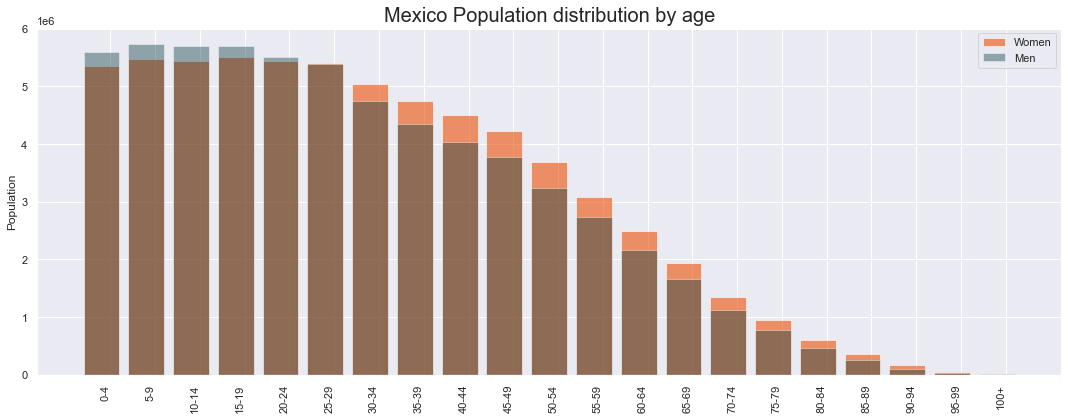

In [102]:
width = 0.8
x = np.arange(len(df_gender_pop.Edad))
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(x, df_gender_pop.F, width, label='Women', color = '#ed5107', alpha=0.6,)
ax.bar(x, df_gender_pop.M, width, label='Men', color = '#02383c', alpha=0.4,)

ax.set_ylabel('Population')
ax.set_title('Mexico Population distribution by age', fontsize = 20)
ax.set_xticks(x + width/4)
ax.set_xticklabels(df_gender_pop.Edad, rotation=90, ha='right')
ax.legend()
fig.tight_layout()

plt.show()

In [103]:
df_hosp = df_positive[['FECHA_INGRESO', 'DIAS_SINT_ING']]
print ('Average number of days between first symptoms to hospitalization : ' + str(df_hosp.DIAS_SINT_ING.mean()))

Average number of days between first symptoms to hospitalization : 4.2953054117027145


In [104]:
df_positive_results = pd.crosstab(df_positive['FECHA_INGRESO'], df_positive.RESULTADO)
df_positive_results = df_positive_results.reset_index()
df_positive_results.rename({1: 'POSITIVO'}, axis=1, inplace=True)

In [105]:
df_positive_results.POSITIVO.sum()

485836

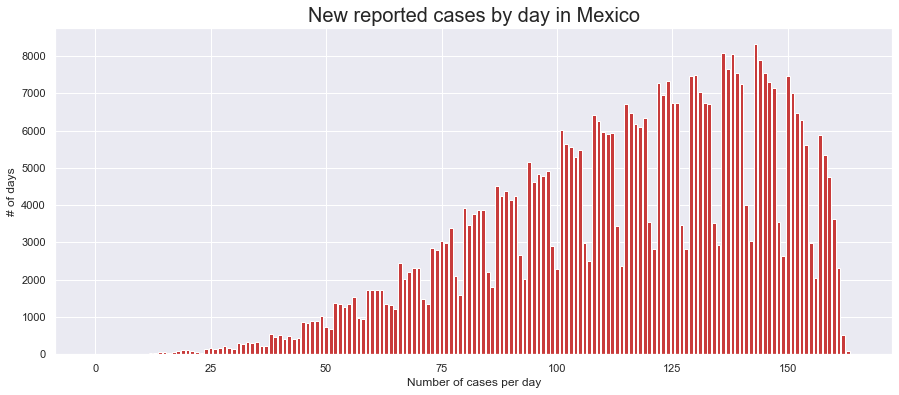

In [106]:
bar_char(df_positive_results.FECHA_INGRESO, 
         df_positive_results.POSITIVO,
         '#c83b3b', 
         'New reported cases by day in Mexico',
         '# of days',
         'Number of cases per day' )

The graph show a sharp decline every 6th and 7th day.